In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import missingno as msno
import warnings

import math
from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')
# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("worker_data.csv")

print(df.columns.tolist())

['tottr', 'hhmem', 'mode_category', 'duration_min', 'trip_distance_miles', 'arr_time', 'dep_time', 'city_from_zip', 'travel_date', 'gender', 'age', 'citizen', 'driver_license', 'transit_pass', 'car_sharing', 'employment', 'job_count', 'empl_sec_loc', 'workday_count', 'hour_per_week', 'workday_flex', 'commute_mode', 'empl_industry', 'empl_occupation', 'disabled', 'transit_trip', 'transit_subsidy', 'walk_trips', 'bike_trips', 'student', 'education', 'person_trips', 'race', 'workday_range', 'incentive', 'vehicle_count', 'bike_count', 'residence_type', 'home_own', 'income', 'persons_count', 'worker_count', 'student_count', 'license_count', 'trip_count', 'home_city', 'vehicle_op_count', 'home_primarycity', 'WMO_code', 'temperature_2m_max (°C)', 'temperature_2m_min (°C)', 'temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)', 'daylight_dur (s)', 'total_ precip (mm)', 'rain (mm)', 'snowfall (cm)', 'precip_hours (h)', 'model_year', 'body_type', 'fuel_type1', 'purchase_type', 'ownership'

In [3]:
# Calculate the percentage of each unique value
value_counts = df['mode_category'].value_counts(normalize=True) * 100
 
# Display the results
print(value_counts)

mode_category
5.0     72.220528
1.0     10.817204
6.0     10.282074
2.0      1.789375
15.0     1.185908
24.0     0.837915
7.0      0.547746
8.0      0.419483
26.0     0.390046
25.0     0.255475
11.0     0.226037
10.0     0.216575
16.0     0.161906
9.0      0.129314
13.0     0.123006
14.0     0.094620
28.0     0.043105
27.0     0.038899
19.0     0.037848
18.0     0.035745
4.0      0.032591
23.0     0.028386
29.0     0.028386
21.0     0.026283
17.0     0.010513
22.0     0.007359
3.0      0.006308
12.0     0.004205
20.0     0.003154
Name: proportion, dtype: float64


In [4]:
def categorize_mode(mode):
    if mode in [1,2, 3, 4]:  # Walk, bike, wheelchair/mobility scooter, other non-motorized
        return 'Active Transportation'
    elif mode in [5,8,10]:  # Auto Driver, motorcycle, rental car
        return 'Auto Driver'
    elif mode in [6,7,9]:  # Auto Passenger, Carpool, taxi
        return 'Auto Passenger'
    elif mode in [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]:  # Transit modes
        return 'Transit'
    else:  # Everything else
        return 'Other'

In [5]:
# Apply the categorization function to the 'Mode of transport' column
df['mode_category'] = df['mode_category'].astype(int).apply(categorize_mode)

# Calculate the percentage of each mode in the dataset
mode_percentage = df['mode_category'].value_counts(normalize=True) * 100

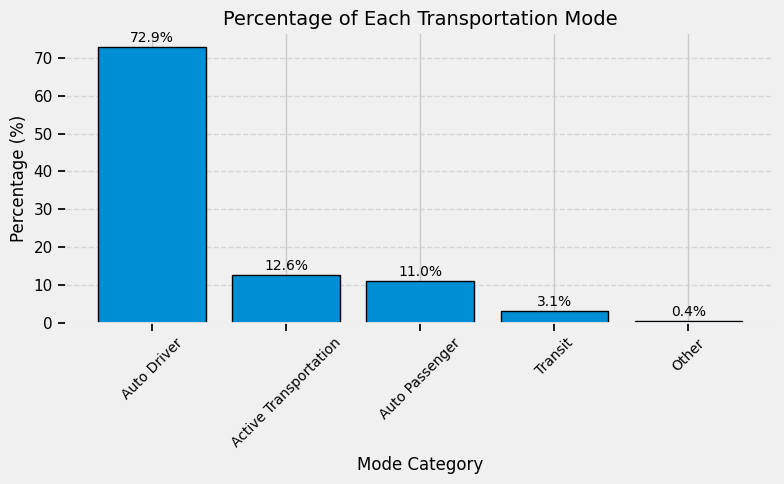

In [6]:
# Plot the percentages as a bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(mode_percentage.index, mode_percentage, edgecolor='black')
 
# Overlay the percentage values on the bars
for bar, percentage in zip(bars, mode_percentage):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate
        bar.get_height() + 0.5,  # Y-coordinate
        f'{percentage:.1f}%',  # Text to display
        ha='center', va='bottom', fontsize=10, color='black'  # Alignment and style
    )
 
# Add chart details
plt.title('Percentage of Each Transportation Mode', fontsize=14)
plt.xlabel('Mode Category', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
df

,tottr,hhmem,mode_category,duration_min,trip_distance_miles,arr_time,dep_time,city_from_zip,travel_date,gender,...,snowfall (cm),precip_hours (h),model_year,body_type,fuel_type1,purchase_type,ownership,transmission,cylinders,veh_type
0,3.0,2.0,Auto Driver,20.0,3.619057,08:35:00,08:15:00,Greater Los Angeles Area,2012-05-12,1.0,...,0.0,0.0,2007.0,8.0,1.0,1.0,1.0,1.0,4.0,2.0
1,5.0,4.0,Auto Driver,20.0,3.587950,15:50:00,15:30:00,Greater Los Angeles Area,2012-05-12,1.0,...,0.0,0.0,2007.0,8.0,1.0,1.0,1.0,1.0,4.0,2.0
2,2.0,1.0,Auto Driver,25.0,19.351621,16:55:00,16:30:00,Greater Los Angeles Area,2012-05-12,1.0,...,0.0,0.0,2007.0,8.0,1.0,1.0,1.0,1.0,4.0,2.0
3,2.0,1.0,Auto Driver,15.0,6.451126,17:55:00,17:40:00,Greater Los Angeles Area,2012-05-12,1.0,...,0.0,0.0,2007.0,8.0,1.0,1.0,1.0,1.0,4.0,2.0
4,2.0,1.0,Auto Driver,20.0,17.657172,19:00:00,18:40:00,Greater Los Angeles Area,2012-05-12,1.0,...,0.0,0.0,2007.0,8.0,1.0,1.0,1.0,1.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95112,1.0,0.0,Auto Driver,4.0,0.181507,16:02:00,15:58:00,San Francisco Bay Area,2013-01-30,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95113,1.0,0.0,Auto Driver,14.0,2.674467,16:47:00,16:33:00,San Francisco Bay Area,2013-01-30,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95114,1.0,0.0,Active Transportation,17.0,2.621383,17:25:00,17:08:00,San Francisco Bay Area,2013-01-30,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95115,1.0,0.0,Active Transportation,94.0,10.356760,19:17:00,17:43:00,San Francisco Bay Area,2013-01-30,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df.describe()

,tottr,hhmem,duration_min,trip_distance_miles,gender,age,citizen,driver_license,transit_pass,car_sharing,...,snowfall (cm),precip_hours (h),model_year,body_type,fuel_type1,purchase_type,ownership,transmission,cylinders,veh_type
count,95117.000000,95117.000000,95117.000000,95117.000000,95117.000000,95117.000000,95117.000000,95117.000000,95117.000000,95117.000000,...,95117.000000,95117.000000,95117.000000,95117.000000,95117.000000,95117.000000,95117.000000,95117.000000,95117.000000,95117.000000
mean,1.534184,0.404765,20.922706,10.351823,1.482080,49.766729,1.175121,1.029311,1.854011,1.978879,...,0.024051,1.572316,1783.505272,2.542963,0.949988,1.278436,0.957211,1.028407,2.561256,1.788461
std,0.980701,0.798897,29.397184,72.665468,0.499681,11.539533,0.380073,0.168678,0.353097,0.143790,...,0.543124,4.256362,626.641932,2.445004,0.435130,0.631536,0.432619,0.534613,1.686343,0.741923
min,1.000000,0.000000,1.000000,0.000000,1.000000,17.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,7.000000,1.212947,1.000000,42.000000,1.000000,1.000000,2.000000,2.000000,...,0.000000,0.000000,1999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
50%,1.000000,0.000000,15.000000,3.331786,1.000000,51.000000,1.000000,1.000000,2.000000,2.000000,...,0.000000,0.000000,2004.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
75%,2.000000,1.000000,25.000000,9.577176,2.000000,58.000000,1.000000,1.000000,2.000000,2.000000,...,0.000000,0.000000,2007.000000,3.000000,1.000000,2.000000,1.000000,1.000000,4.000000,2.000000
max,31.000000,5.000000,1080.000000,15815.056366,2.000000,94.000000,2.000000,2.000000,2.000000,2.000000,...,35.210000,24.000000,2013.000000,13.000000,5.000000,2.000000,4.000000,3.000000,7.000000,6.000000


In [9]:
df['mode_category'].unique()

array(['Auto Driver', 'Active Transportation', 'Transit',
       'Auto Passenger', 'Other'], dtype=object)

In [10]:
# check for numeric values 
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

print("Numeric columns:")
print(numeric_columns)

Numeric columns:
['tottr', 'hhmem', 'duration_min', 'trip_distance_miles', 'gender', 'age', 'citizen', 'driver_license', 'transit_pass', 'car_sharing', 'employment', 'job_count', 'empl_sec_loc', 'workday_count', 'hour_per_week', 'workday_flex', 'commute_mode', 'empl_industry', 'empl_occupation', 'disabled', 'transit_trip', 'transit_subsidy', 'walk_trips', 'bike_trips', 'student', 'education', 'person_trips', 'race', 'incentive', 'vehicle_count', 'bike_count', 'residence_type', 'home_own', 'income', 'persons_count', 'worker_count', 'student_count', 'license_count', 'trip_count', 'vehicle_op_count', 'WMO_code', 'temperature_2m_max (°C)', 'temperature_2m_min (°C)', 'temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)', 'daylight_dur (s)', 'total_ precip (mm)', 'rain (mm)', 'snowfall (cm)', 'precip_hours (h)', 'model_year', 'body_type', 'fuel_type1', 'purchase_type', 'ownership', 'transmission', 'cylinders', 'veh_type']


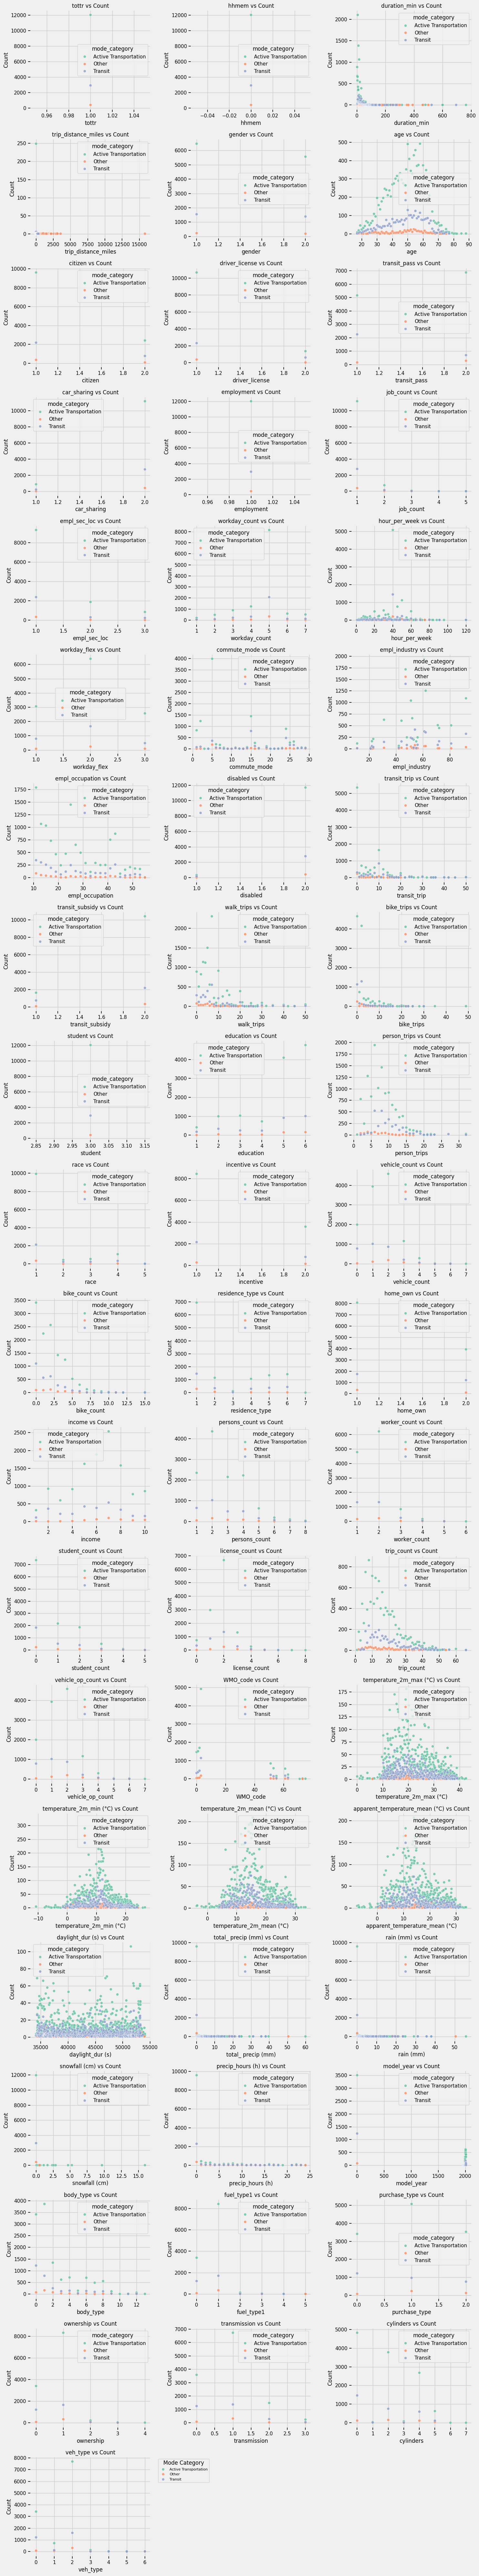

In [ ]:
# Filter numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

# Ensure 'mode_category' matches the specified modes
modes_to_plot = ['Auto Driver', 'Active Transportation', 'Transit', 'Auto Passenger', 'Other']
df_filtered = df[df['mode_category'].isin(modes_to_plot)]

# Determine grid size
n_cols = 3
n_rows = math.ceil(len(numeric_columns) / n_cols)

# Create the plot grid
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, feature in enumerate(numeric_columns):
    plt.subplot(n_rows, n_cols, i + 1)
    
    # Group data by numeric feature and mode to calculate counts
    grouped_data = df_filtered.groupby(['mode_category', feature]).size().reset_index(name='count')
    
    # Scatter plot for the current feature
    sns.scatterplot(
        data=grouped_data,
        x=feature,
        y='count',
        hue='mode_category',
        palette='Set2',
        alpha=0.8
    )
    
    plt.title(f'{feature} vs Count')
    plt.xlabel(feature)
    plt.ylabel('Count')

# Adjust layout
plt.tight_layout()
plt.legend(title='Mode Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.show()

In [12]:
# Check for null values in numeric columns
null_counts = df[numeric_columns].isnull().sum()

# Print columns with null values
print("Numeric columns with null or NaN values:")
print(null_counts[null_counts > 0])

Numeric columns with null or NaN values:
commute_mode    13984
dtype: int64


In [13]:
df.shape[0]

95117

In [14]:
# Select non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['number']).columns.tolist()

# Print the non-numeric columns
print("Non-numeric columns:")
print(non_numeric_columns)

Non-numeric columns:
['mode_category', 'arr_time', 'dep_time', 'city_from_zip', 'travel_date', 'workday_range', 'home_city', 'home_primarycity']


In [15]:
# Create a DataFrame with only non-numeric columns
df_non_numeric = df[non_numeric_columns]

# Display the DataFrame with non-numeric columns
df_non_numeric.head()

,mode_category,arr_time,dep_time,city_from_zip,travel_date,workday_range,home_city,home_primarycity
0,Auto Driver,08:35:00,08:15:00,Greater Los Angeles Area,2012-05-12,"[8, nan, nan, nan, nan, nan, nan]",SAN DIEGO,SAN DIEGO
1,Auto Driver,15:50:00,15:30:00,Greater Los Angeles Area,2012-05-12,"[8, nan, nan, nan, nan, nan, nan]",SAN DIEGO,SAN DIEGO
2,Auto Driver,16:55:00,16:30:00,Greater Los Angeles Area,2012-05-12,"[8, nan, nan, nan, nan, nan, nan]",SAN DIEGO,SAN DIEGO
3,Auto Driver,17:55:00,17:40:00,Greater Los Angeles Area,2012-05-12,"[8, nan, nan, nan, nan, nan, nan]",SAN DIEGO,SAN DIEGO
4,Auto Driver,19:00:00,18:40:00,Greater Los Angeles Area,2012-05-12,"[8, nan, nan, nan, nan, nan, nan]",SAN DIEGO,SAN DIEGO


In [16]:
# Check the data type of each column
column_types = df_non_numeric.dtypes

# Display the types
print("Data types of each column:")
print(column_types)

Data types of each column:
mode_category       object
arr_time            object
dep_time            object
city_from_zip       object
travel_date         object
workday_range       object
home_city           object
home_primarycity    object
dtype: object


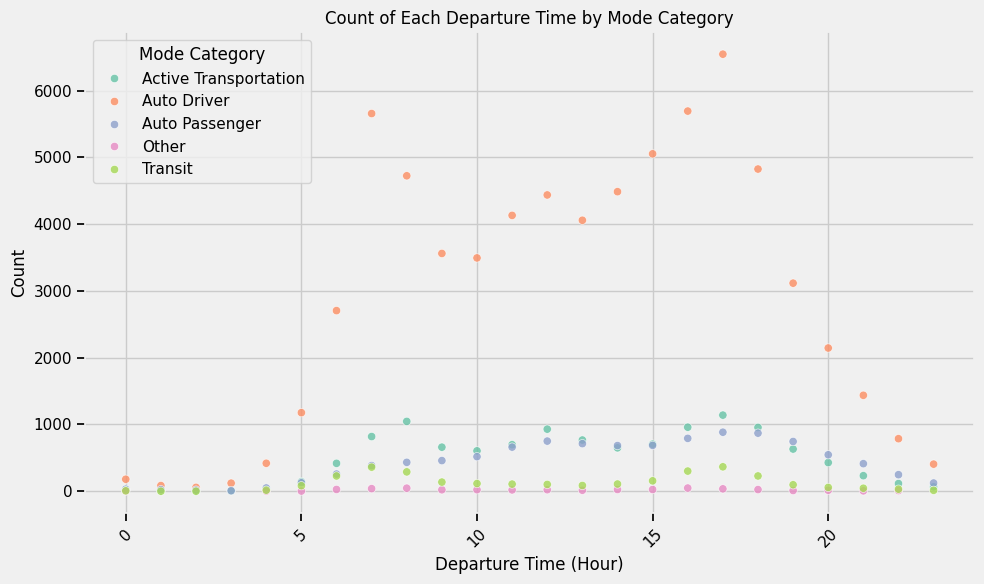

In [17]:
# Convert 'dep_time' to datetime format
df['dep_time'] = pd.to_datetime(df['dep_time'], errors='coerce')

# Filter out rows where 'dep_time' could not be converted (NaT values)
df_filtered = df.dropna(subset=['dep_time'])

# Group by 'dep_time' and 'mode_category' to get the counts
grouped_data = df_filtered.groupby([df['dep_time'].dt.hour, 'mode_category']).size().reset_index(name='count')

# Plotting the count of each departure time, color-coded by mode category
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped_data, x='dep_time', y='count', hue='mode_category', palette='Set2', alpha=0.8)

# Customize the plot
plt.title('Count of Each Departure Time by Mode Category')
plt.xlabel('Departure Time (Hour)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Mode Category')
plt.tight_layout()

plt.show()

# Temporal Features EDA

In [18]:
# Convert 'travel_date' to datetime format
df_filtered['travel_date'] = pd.to_datetime(df_filtered['travel_date'], errors='coerce')

In [19]:
# Sort the dataset by time
df_filtered = df_filtered.sort_values(by='travel_date', ascending=True).reset_index(drop=True)

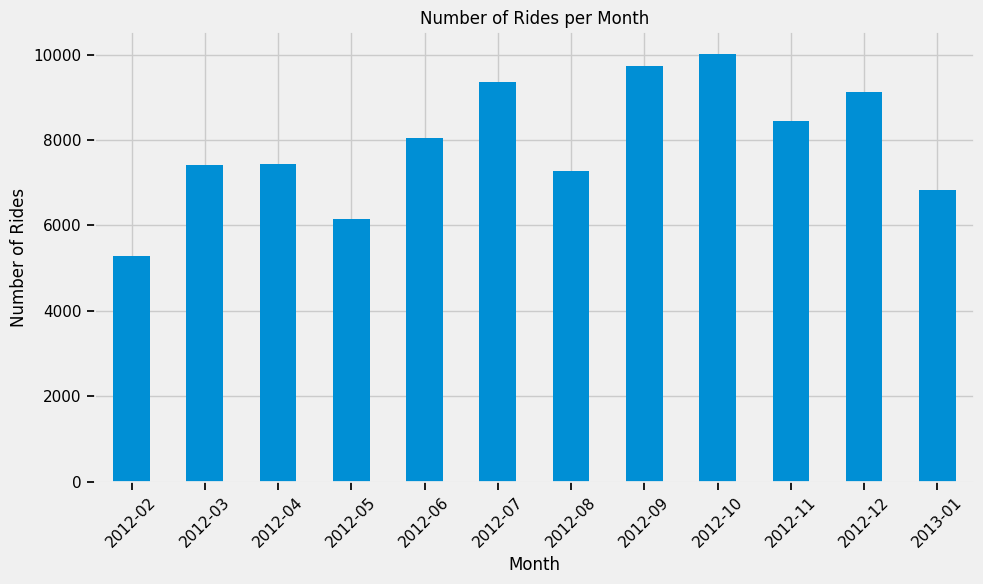

In [20]:
# Extract the year and month (ignoring the day) from 'travel_date'
df_filtered['month'] = df_filtered['travel_date'].dt.to_period('M')

# Count the number of rides per month
rides_per_month = df_filtered['month'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10,6))
rides_per_month.plot(kind='bar')

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('Number of Rides')
plt.title('Number of Rides per Month')

# Rotate x labels for better readability if needed
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


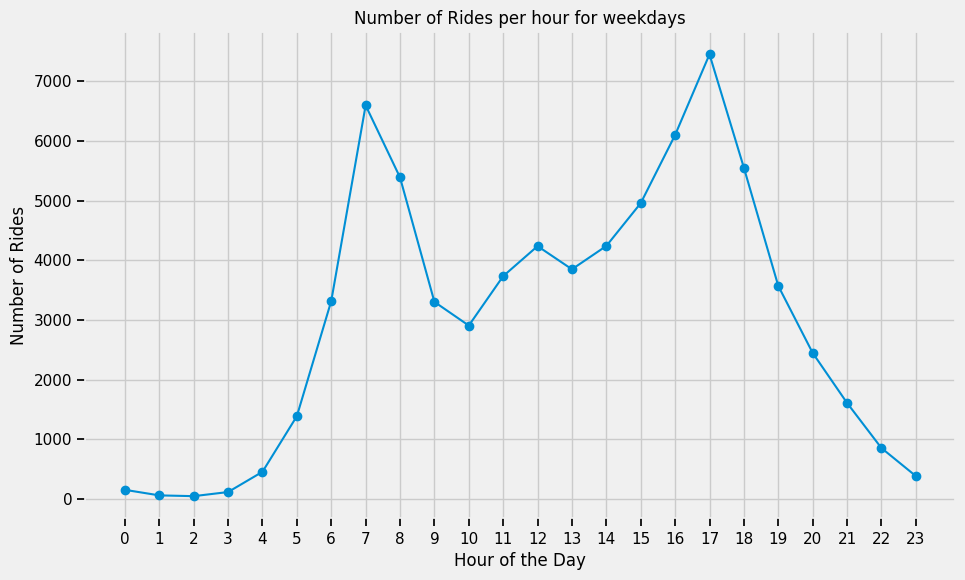

In [21]:
# Convert 'dep_time' to datetime format
df_filtered['dep_time'] = pd.to_datetime(df_filtered['dep_time'], errors='coerce')

df_filtered['dep_time_hr'] = df_filtered['dep_time'].dt.hour

df_filtered['day_of_week'] = df_filtered['travel_date'].dt.dayofweek

# Filter the days of the week to only include saturday and sunday
selected_days = df_filtered[df_filtered['day_of_week'].isin([0, 1, 2, 3, 4])]

# Count the number of rides per month
rides_per_hour = selected_days['dep_time_hr'].value_counts().sort_index()

plt.figure(figsize=(10,6))
plt.plot(rides_per_hour.index, rides_per_hour.values, marker='o', linestyle='-')
plt.title('Number of Rides per hour for weekdays')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')
plt.grid(True)
plt.xticks(range(0, 24))  # Set x-axis ticks for each hour
plt.show()

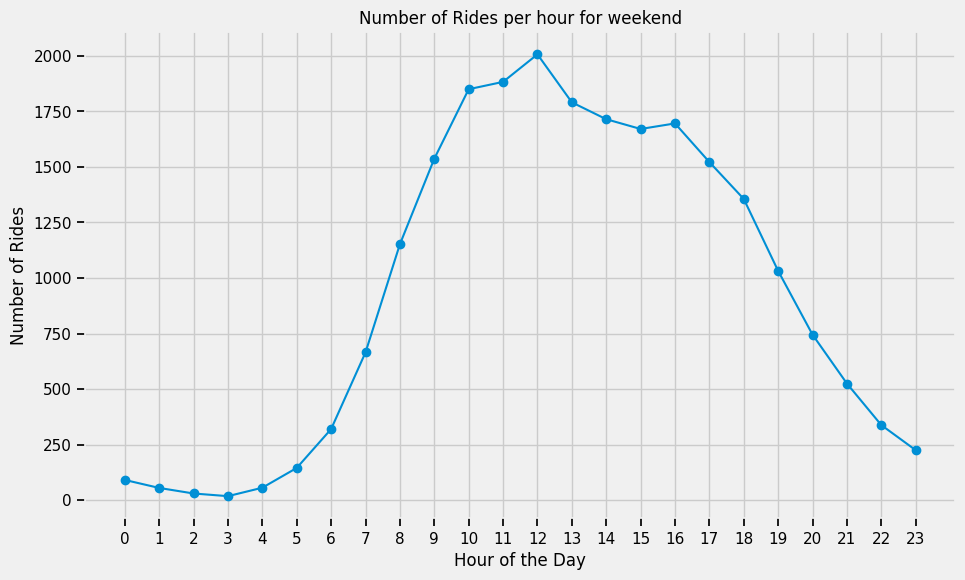

In [22]:
# Filter the days of the week to only include saturday and sunday
selected_days_we = df_filtered[df_filtered['day_of_week'].isin([5,6])]

# Count the number of rides per month
rides_per_hour_we = selected_days_we['dep_time_hr'].value_counts().sort_index()

plt.figure(figsize=(10,6))
plt.plot(rides_per_hour_we.index, rides_per_hour_we.values, marker='o', linestyle='-')
plt.title('Number of Rides per hour for weekend')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')
plt.grid(True)
plt.xticks(range(0, 24))  # Set x-axis ticks for each hour
plt.show()

# Socio-demographics Features EDA 

# Geospatial Features EDA

In [23]:
df_non_numeric.head()

,mode_category,arr_time,dep_time,city_from_zip,travel_date,workday_range,home_city,home_primarycity
0,Auto Driver,08:35:00,08:15:00,Greater Los Angeles Area,2012-05-12,"[8, nan, nan, nan, nan, nan, nan]",SAN DIEGO,SAN DIEGO
1,Auto Driver,15:50:00,15:30:00,Greater Los Angeles Area,2012-05-12,"[8, nan, nan, nan, nan, nan, nan]",SAN DIEGO,SAN DIEGO
2,Auto Driver,16:55:00,16:30:00,Greater Los Angeles Area,2012-05-12,"[8, nan, nan, nan, nan, nan, nan]",SAN DIEGO,SAN DIEGO
3,Auto Driver,17:55:00,17:40:00,Greater Los Angeles Area,2012-05-12,"[8, nan, nan, nan, nan, nan, nan]",SAN DIEGO,SAN DIEGO
4,Auto Driver,19:00:00,18:40:00,Greater Los Angeles Area,2012-05-12,"[8, nan, nan, nan, nan, nan, nan]",SAN DIEGO,SAN DIEGO


In [24]:
df_non_numeric['home_city'].unique()

array(['SAN DIEGO', 'MERCED', 'SAN FRANCISCO', 'ELK GROVE', 'SACRAMENTO',
       'LOS ANGELES', 'CARLSBAD', 'SAN JOSE', 'LONG BEACH', 'MARTINEZ',
       'MILLBRAE', 'BERKELEY', 'WISHON', 'BRENTWOOD', 'CLAYTON',
       'MONTCLAIR', 'REDWOOD CITY', 'THOUSAND OAKS', 'SYLMAR',
       'PALO ALTO', 'SANTA ROSA', 'STOCKTON', 'BONITA', 'VALLEY CENTER',
       'PALM DESERT', 'LIVERMORE', 'TORRANCE', 'LAKESIDE', 'DIAMOND BAR',
       'RIVERSIDE', 'POMONA', 'NEWHALL', 'COLTON', 'TULARE',
       'CHULA VISTA', 'SARATOGA', 'DALY CITY', 'HAYWARD', 'BAKERSFIELD',
       'ONTARIO', 'MILL VALLEY', 'OAKLAND', 'CITRUS HEIGHTS',
       'NORTHRIDGE', 'BIXBY KNOLLS', 'COMPTON', 'VACAVILLE', 'CARMICHAEL',
       'DISCOVERY BAY', 'WHEATLAND', 'WALNUT CREEK', 'SAN LEANDRO',
       'SUN CITY', 'HEMET', 'COSTA MESA', 'SANTA CRUZ', 'LA PALMA',
       'ALHAMBRA', 'FRESNO', 'SEAL BEACH', 'CLAREMONT', 'RESCUE',
       'BURLINGAME', 'INGLEWOOD', 'NAPA', 'VENTURA', 'SANTEE',
       'ROSEVILLE', 'SAN MARCOS', 'HOLLISTE

In [25]:
df_non_numeric['city_from_zip'].unique()

array(['Greater Los Angeles Area', 'Stockton Area',
       'San Francisco Bay Area', 'Sacramento Area', 'Fresno Area',
       'San Diego County', 'Riverside-San Bernardino', 'Bakersfield Area'],
      dtype=object)

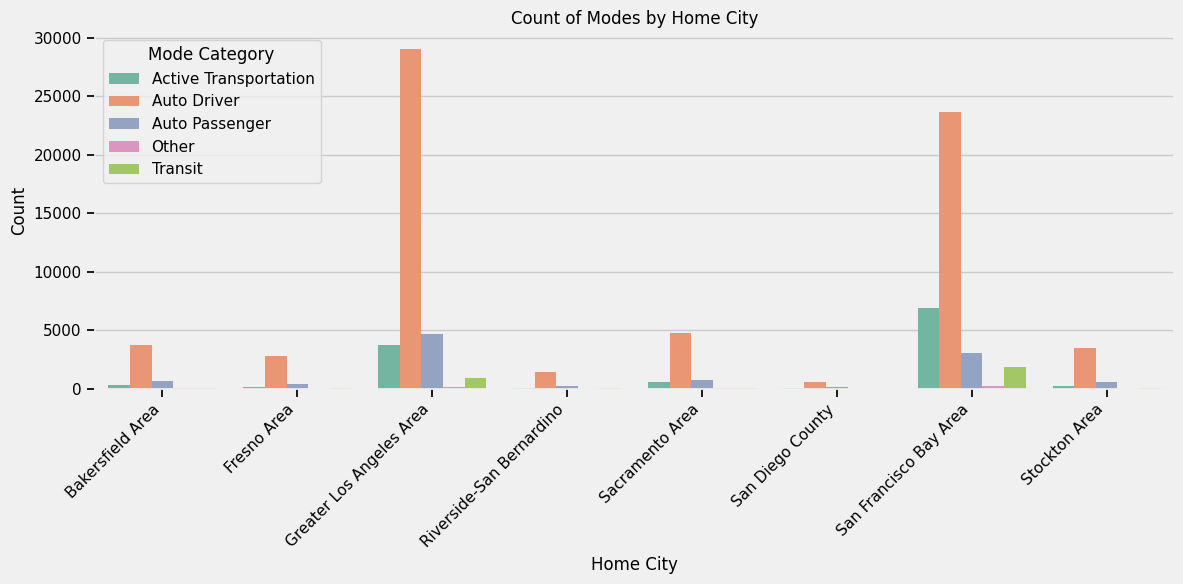

In [26]:

# Group by 'home_city' and 'mode_category' to get counts
home_city_mode_counts = df_filtered.groupby(['city_from_zip', 'mode_category']).size().reset_index(name='count')

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(data=home_city_mode_counts, x='city_from_zip', y='count', hue='mode_category', palette='Set2')

# Customize the plot
plt.title('Count of Modes by Home City')
plt.xlabel('Home City')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Mode Category')
plt.tight_layout()

plt.show()

In [27]:
import folium
from folium import Circle
from folium.plugins import HeatMap

In [28]:
# Calculate mode counts by city_from_zip
mode_counts = df_filtered.groupby(['city_from_zip', 'mode_category']).size().reset_index(name='count')

# Coordinates for the centers of the mentioned areas (approximations)
area_centers = {
    'Greater Los Angeles Area': (34.0522, -118.2437),
    'Sacramento Area': (38.5816, -121.4944),
    'San Francisco Bay Area': (37.7749, -122.4194),
    'Stockton Area': (37.9577, -121.2908),
    'San Diego County': (32.7157, -117.1611),
    'Riverside-San Bernardino': (34.0522, -117.2437),
    'Fresno Area': (36.7378, -119.7871),
    'Bakersfield Area': (35.3733, -119.0187),
}

# Create the map centered around California
map_center = (36.7783, -119.4179)
m = folium.Map(location=map_center, zoom_start=6)

# Add markers for each area, color-coded by mode category
for area, coords in area_centers.items():
    area_modes = mode_counts[mode_counts['city_from_zip'] == area]
    
    # For simplicity, we are color-coding by mode_category, you can modify this based on the logic you want
    for _, row in area_modes.iterrows():
        mode = row['mode_category']
        count = row['count']
        
        # Set color based on the mode (you can customize the colors)
        mode_colors = {
            'Auto': 'yellow',
            'Transit': 'green',
            'Active Transportation': 'orange',
            'Other': 'red'
        }
        
        # Add a circle marker with color based on the mode
        folium.CircleMarker(
            location=coords,
            radius=count / 150,  # Adjust size based on count (you can modify this factor)
            color=mode_colors.get(mode, 'gray'),
            fill=True,
            fill_color=mode_colors.get(mode, 'gray'),
            fill_opacity=0.5,
            popup=f'{area}: {mode} ({count})'
        ).add_to(m)

# Display the map
m

In [29]:
# Calculate mode counts by city_from_zip
mode_counts = df_filtered.groupby(['city_from_zip', 'mode_category']).size().reset_index(name='count')

# Coordinates for the centers of the mentioned areas (approximations)
area_centers = {
    'Greater Los Angeles Area': (34.0522, -118.2437),
    'Sacramento Area': (38.5816, -121.4944),
    'San Francisco Bay Area': (37.7749, -122.4194),
    'Stockton Area': (37.9577, -121.2908),
    'San Diego County': (32.7157, -117.1611),
    'Riverside-San Bernardino': (34.0522, -117.2437),
    'Fresno Area': (36.7378, -119.7871),
    'Bakersfield Area': (35.3733, -119.0187),
}

# Mode color dictionary for heatmap
mode_colors = {
    'Auto': 'blue',
    'Transit': 'green',
    'Active Transportation': 'orange',
    'Other': 'red'
}

# Function to generate a heatmap for a specific mode
def create_heatmap_for_mode(mode):
    # Filter the mode data
    mode_data = mode_counts[mode_counts['mode_category'] == mode]
    
    # Create a map centered around California
    map_center = (36.7783, -119.4179)
    m = folium.Map(location=map_center, zoom_start=6)
    
    # Prepare data for the heatmap (latitude, longitude, intensity)
    heat_data = []
    for _, row in mode_data.iterrows():
        city = row['city_from_zip']
        count = row['count']
        coords = area_centers[city]
        
        # Add the data point (latitude, longitude, intensity)
        heat_data.append([coords[0], coords[1], count])
    
    # Add heatmap layer for this mode
    HeatMap(heat_data, min_opacity=0.3, max_val=max(mode_counts['count']), radius=25, blur=5, gradient={0: 'gray', 0.5: mode_colors[mode], 1: mode_colors[mode]}).add_to(m)
    # just print it for now 
    # Save the map to an HTML file just print it for now 
    #m.save(f"heatmap_{mode}.html")
    return m

# Generate separate maps for each mode
for mode in mode_colors.keys():
    print(mode)
    create_heatmap_for_mode(mode)



Auto
Transit
Active Transportation
Other


In [30]:
create_heatmap_for_mode('Active Transportation')

#### Feature Enginnering

In [32]:
df_filtered

,tottr,hhmem,mode_category,duration_min,trip_distance_miles,arr_time,dep_time,city_from_zip,travel_date,gender,...,fuel_type1,purchase_type,ownership,transmission,cylinders,veh_type,month,dep_time_hr,day_of_week,day_w
0,1.0,0.0,Auto Driver,15.0,6.586343,11:45:00,2024-11-30 11:30:00,San Francisco Bay Area,2012-02-01,1.0,...,1.0,2.0,1.0,1.0,2.0,2.0,2012-02,11,2,2
1,1.0,0.0,Auto Driver,14.0,4.552667,19:01:00,2024-11-30 18:47:00,San Francisco Bay Area,2012-02-01,2.0,...,1.0,1.0,1.0,2.0,4.0,2.0,2012-02,18,2,2
2,1.0,0.0,Auto Driver,12.0,4.552667,20:57:00,2024-11-30 20:45:00,San Francisco Bay Area,2012-02-01,2.0,...,1.0,1.0,1.0,2.0,4.0,2.0,2012-02,20,2,2
3,2.0,1.0,Auto Driver,10.0,4.344477,06:59:00,2024-11-30 06:49:00,San Francisco Bay Area,2012-02-01,1.0,...,1.0,2.0,1.0,2.0,2.0,1.0,2012-02,6,2,2
4,1.0,0.0,Auto Driver,50.0,30.622834,07:50:00,2024-11-30 07:00:00,San Francisco Bay Area,2012-02-01,1.0,...,1.0,2.0,1.0,2.0,2.0,1.0,2012-02,7,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95112,1.0,0.0,Auto Driver,78.0,61.186158,08:18:00,2024-11-30 07:00:00,San Francisco Bay Area,2013-01-31,2.0,...,1.0,1.0,1.0,1.0,2.0,2.0,2013-01,7,3,3
95113,1.0,0.0,Auto Driver,8.0,1.621871,16:00:00,2024-11-30 15:52:00,San Francisco Bay Area,2013-01-31,2.0,...,1.0,1.0,1.0,1.0,2.0,2.0,2013-01,15,3,3
95114,1.0,0.0,Auto Driver,75.0,59.525036,17:55:00,2024-11-30 16:40:00,Fresno Area,2013-01-31,2.0,...,1.0,1.0,1.0,1.0,2.0,2.0,2013-01,16,3,3
95115,6.0,0.0,Auto Passenger,18.0,23.994998,15:50:00,2024-11-30 15:32:00,Sacramento Area,2013-01-31,1.0,...,2.0,1.0,1.0,1.0,5.0,3.0,2013-01,15,3,3


In [33]:
import ast

# First convert the units column into an actual list
df_filtered.loc[:, 'workday_range'] = df_filtered['workday_range'].str.strip("[]").str.replace("'", "").str.split(", ")

# Function to handle 'nan' and numbers in a string list
def convert_list_to_int_or_nan(x):
    if isinstance(x, str):
        # Convert string to list using ast.literal_eval
        x = ast.literal_eval(x)

    # Now process the list, convert numeric strings to int and 'nan' to np.nan
    result = []
    for val in x:
        if isinstance(val, str):
            # If it's a string number (e.g., '5.0', '6.0'), convert to float or int
            if val.lower() != 'nan':
                result.append(int(float(val)))  # Convert numeric string to an integer
            else:
                result.append(np.nan)  # Replace 'nan' string with np.nan
        elif isinstance(val, (float, int)):
            result.append(int(val))  # Convert numeric types to integer
        else:
            result.append(np.nan)  # Handle non-numeric values

    return result

# Apply this function to the 'workday_range' column
df_filtered.loc[:, 'workday_range'] = df_filtered['workday_range'].apply(convert_list_to_int_or_nan)

In [ ]:
def check_workday(travel_date, workday_range):
    # If the person works Monday to Friday (8)
    if 8 in workday_range:
        if travel_date == 5 or travel_date == 6:  # Saturday (5) or Sunday (6)
            return 2  # Not a workday
        else:
            return 1  # Monday to Friday is a workday
    # If the person works on specific days in workday_range (1-7)
    elif (travel_date + 1) in workday_range:  # Convert travel_date 0-6 to 1-7 (Monday=1, Sunday=7)
        return 1  # It is a workday
    else:
        return 2  # Not a workday

# Apply the function to the DataFrame
df_filtered['is_workday'] = df_filtered.apply(lambda row: check_workday(row['day_of_week'], row['workday_range']), axis=1)


# Display the updated DataFrame with the new 'is_workday' column
print(df_filtered[['day_of_week', 'workday_range', 'is_workday']])

       day_w                      workday_range  is_workday
0          2  [8, nan, nan, nan, nan, nan, nan]           1
1          2    [7, 1, nan, nan, nan, nan, nan]           2
2          2    [7, 1, nan, nan, nan, nan, nan]           2
3          2  [8, nan, nan, nan, nan, nan, nan]           1
4          2  [8, nan, nan, nan, nan, nan, nan]           1
...      ...                                ...         ...
95112      3        [1, 2, 3, 4, nan, nan, nan]           1
95113      3        [1, 2, 3, 4, nan, nan, nan]           1
95114      3        [1, 2, 3, 4, nan, nan, nan]           1
95115      3  [8, nan, nan, nan, nan, nan, nan]           1
95116      3  [8, nan, nan, nan, nan, nan, nan]           1

[95117 rows x 3 columns]


In [ ]:
def feature_engineering(data):
    data_copy = data.copy()
    return data_copy


#### Feature Selection

In [35]:
def selected_feature(data):
    
    feature_selected = ['tottr',
                        'gender',
                        'race',
                        'age',
                        'incentive',
                        'vehicle_count',
                        'income',
                        'worker_count',
                        'is_workday',
                        'workday_count',
                        'driver_license',
                        'job_count',
                        'apparent_temperature_mean (°C)',
                        'WMO_code']

    selected_data = data[feature_selected]
    
    return selected_data

#### Train the Model

In [36]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# Assume df is your DataFrame and 'y' is the target column

# Step 1: Split the data into train (70%) and temp (30%)
train_df, temp_df = train_test_split(df_filtered, test_size=0.3, stratify=df['mode_category'], random_state=42)

# Step 2: Split the temp set into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['mode_category'], random_state=42)

# Step 3: Separate features (X) and target (y) for the training set
X_train = selected_feature(train_df)
y_train = train_df['mode_category']

# Step 4: Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 5: Print class distribution after SMOTE
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_resampled))

# Step 6: Separate features and target for validation and test sets
X_val = selected_feature(val_df)
y_val = val_df['mode_category']

X_test = selected_feature(test_df)
y_test = test_df['mode_category']

# Outputs
print(f"Training set size: {X_train_resampled.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Class distribution before SMOTE: Counter({'Auto Driver': 48437, 'Active Transportation': 8432, 'Auto Passenger': 7356, 'Transit': 2052, 'Other': 304})
Class distribution after SMOTE: Counter({'Auto Driver': 48437, 'Active Transportation': 48437, 'Auto Passenger': 48437, 'Transit': 48437, 'Other': 48437})
Training set size: 242185
Validation set size: 14268
Test set size: 14268


In [37]:
model = RandomForestClassifier(random_state=42)

# Fit and predict
model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [38]:
y_pred = model.predict(X_val)

#### Check the performance of the model

In [39]:
accuracy = accuracy_score(y_val, y_pred)

print(f"Accuracy of the Random Forest Classifier: {accuracy * 100:.2f}%")

Accuracy of the Random Forest Classifier: 84.55%


In [40]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5)

print(f"Cross-Validated Accuracy: {cv_scores.mean() * 100:.2f}%")

Cross-Validated Accuracy: 91.94%


In [ ]:
from sklearn.metrics import classification_report, f1_score

# Step 1: Check class distribution
unique, counts = np.unique(y_val, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)

# Step 2: Generate classification report
report = classification_report(y_val, y_pred, target_names=['Active Transportation', 'Auto Driver', 'Auto Passenger', 'Other', 'Transit'], digits=3)
print("\nClassification Report:\n", report)

# Step 3: Calculate weighted F1-score
weighted_f1 = f1_score(y_val, y_pred, average='weighted')
print("\nWeighted F1-Score:", weighted_f1)

Class Distribution: {'Active Transportation': np.int64(1798), 'Auto Driver': np.int64(10431), 'Auto Passenger': np.int64(1534), 'Other': np.int64(61), 'Transit': np.int64(444)}

Classification Report:
                        precision    recall  f1-score   support

          Auto Driver      0.572     0.556     0.564      1798
Active Transportation      0.928     0.927     0.928     10431
              Transit      0.858     0.799     0.827      1534
       Auto Passenger      0.267     0.328     0.294        61
                Other      0.245     0.331     0.282       444

             accuracy                          0.846     14268
            macro avg      0.574     0.588     0.579     14268
         weighted avg      0.852     0.846     0.848     14268


Weighted F1-Score: 0.848348159127268



Top 10 Important Features:
                           Feature  Importance
0                            tottr    0.203054
3                              age    0.161520
12  apparent_temperature_mean (°C)    0.159886
13                        WMO_code    0.093445
6                           income    0.073250
5                    vehicle_count    0.063933
9                    workday_count    0.061059
1                           gender    0.052261
2                             race    0.032748
7                     worker_count    0.027634


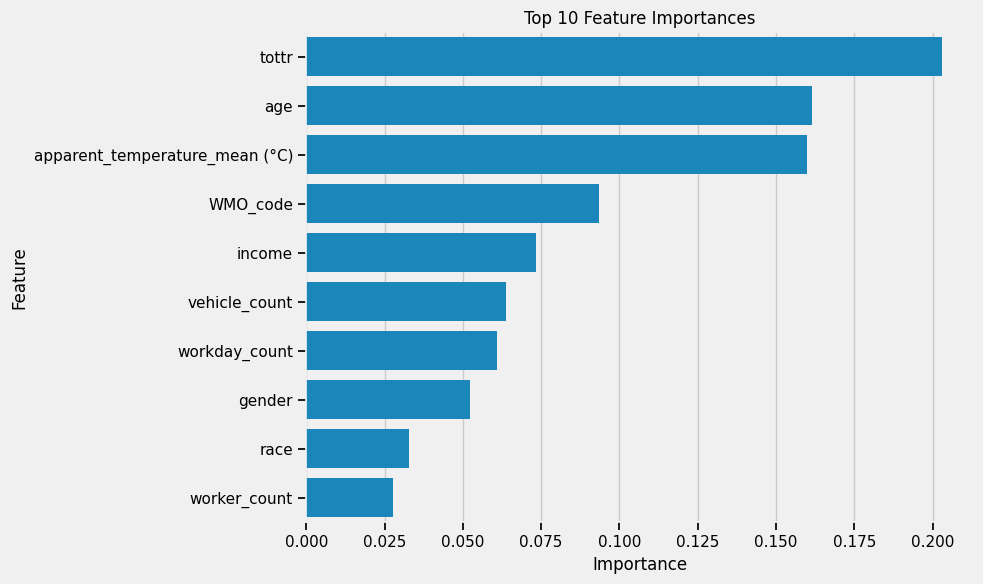

In [43]:
# Feature importances
importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print("\nTop 10 Important Features:")
print(feature_importance_df.head(10))

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

##### Now let's see if we can improve our model through hyper-parameter tuning. Get the parameters.

In [44]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [45]:
# # Create the RandomForestClassifier model
# rf = RandomForestClassifier()

# # Define the hyperparameters to tune
# param_dist = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'bootstrap': [True, False]
# }

# # Perform RandomizedSearchCV
# random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
#                                    n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1)

# # Fit the model
# random_search.fit(X_train_resampled, y_train_resampled)

# # Print the best parameters and the best score
# print("Best parameters found: ", random_search.best_params_)
# print("Best cross-validation score: ", random_search.best_score_)


In [46]:
df_filtered

,tottr,hhmem,mode_category,duration_min,trip_distance_miles,arr_time,dep_time,city_from_zip,travel_date,gender,...,purchase_type,ownership,transmission,cylinders,veh_type,month,dep_time_hr,day_of_week,day_w,is_workday
0,1.0,0.0,Auto Driver,15.0,6.586343,11:45:00,2024-11-30 11:30:00,San Francisco Bay Area,2012-02-01,1.0,...,2.0,1.0,1.0,2.0,2.0,2012-02,11,2,2,1
1,1.0,0.0,Auto Driver,14.0,4.552667,19:01:00,2024-11-30 18:47:00,San Francisco Bay Area,2012-02-01,2.0,...,1.0,1.0,2.0,4.0,2.0,2012-02,18,2,2,2
2,1.0,0.0,Auto Driver,12.0,4.552667,20:57:00,2024-11-30 20:45:00,San Francisco Bay Area,2012-02-01,2.0,...,1.0,1.0,2.0,4.0,2.0,2012-02,20,2,2,2
3,2.0,1.0,Auto Driver,10.0,4.344477,06:59:00,2024-11-30 06:49:00,San Francisco Bay Area,2012-02-01,1.0,...,2.0,1.0,2.0,2.0,1.0,2012-02,6,2,2,1
4,1.0,0.0,Auto Driver,50.0,30.622834,07:50:00,2024-11-30 07:00:00,San Francisco Bay Area,2012-02-01,1.0,...,2.0,1.0,2.0,2.0,1.0,2012-02,7,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95112,1.0,0.0,Auto Driver,78.0,61.186158,08:18:00,2024-11-30 07:00:00,San Francisco Bay Area,2013-01-31,2.0,...,1.0,1.0,1.0,2.0,2.0,2013-01,7,3,3,1
95113,1.0,0.0,Auto Driver,8.0,1.621871,16:00:00,2024-11-30 15:52:00,San Francisco Bay Area,2013-01-31,2.0,...,1.0,1.0,1.0,2.0,2.0,2013-01,15,3,3,1
95114,1.0,0.0,Auto Driver,75.0,59.525036,17:55:00,2024-11-30 16:40:00,Fresno Area,2013-01-31,2.0,...,1.0,1.0,1.0,2.0,2.0,2013-01,16,3,3,1
95115,6.0,0.0,Auto Passenger,18.0,23.994998,15:50:00,2024-11-30 15:32:00,Sacramento Area,2013-01-31,1.0,...,1.0,1.0,1.0,5.0,3.0,2013-01,15,3,3,1
